In [17]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

spark

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data point indexing

In [26]:
DATA_DIR = "main/ycsb"

client_sdf = spark.read.csv(f"{DATA_DIR}/*/client/0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

server_sdf = spark.read.csv(f"{DATA_DIR}/*/server/0-0/metadata.csv", header=True)\
    .withColumn(
        "prefix",
        ancestor_udf(F.input_file_name(), lit(3))
    )

index_sdf = server_sdf.join(client_sdf, on='prefix')\
    .withColumn("duration", col("duration").cast(T.IntegerType()))\
    .withColumn("txns", col("txns").cast(T.IntegerType()))\
    .withColumn("clients", col("clients").cast(T.IntegerType()))\
    .withColumn("rate", col("rate").cast(T.IntegerType()))\
    .withColumn("sample", col("sample").cast(T.IntegerType()))

index_sdf.cache().toPandas()

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:records,wl:mh_homes,wl:mp,wl:hot_records,wl:mp_parts,wl:hot,wl:writes,wl:value_size,wl:nearest,wl:sp_partition
0,file:///home/ctring/data/slog/main/ycsb/baseli...,1.0.879,baseline.conf,15,1000000,100,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
1,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1.0.883,ddr_ts.conf,15,1000000,100,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
2,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1.0.883,ddr_ts.conf,15,1000000,125,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
3,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1.0.883,ddr_ts.conf,15,1000000,375,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
4,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1.0.883,ddr_ts.conf,15,1000000,500,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
5,file:///home/ctring/data/slog/main/ycsb/baseli...,1.0.879,baseline.conf,15,1000000,50,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
6,file:///home/ctring/data/slog/main/ycsb/baseli...,1.0.879,baseline.conf,15,1000000,75,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
7,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1.0.883,ddr_ts.conf,15,1000000,50,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
8,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1.0.883,ddr_ts.conf,15,1000000,75,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1


# Throughput

In [27]:
# Extract all prefixes in the index
throughput_df = index_sdf.select("prefix").toPandas().set_index("prefix")
# Compute the throughput of each prefix
throughput_df["throughput"] = throughput_df.index.map(lambda p: throughput(spark, p).cache().first().throughput)
# Associate metadata from the index to the throughputs
throughput_df = throughput_df.join(index_sdf.toPandas().set_index("prefix"), on="prefix").reset_index(drop=True)
# Try to cast columns to appropriate types 
throughput_df = throughput_df.convert_dtypes()

throughput_df.sort_values(by="config_name")

,throughput,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:records,wl:mh_homes,wl:mp,wl:hot_records,wl:mp_parts,wl:hot,wl:writes,wl:value_size,wl:nearest,wl:sp_partition
0,9778.53729,1.0.879,baseline.conf,15,1000000,100,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
5,5232.638788,1.0.879,baseline.conf,15,1000000,50,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
6,7672.386562,1.0.879,baseline.conf,15,1000000,75,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
1,14090.193007,1.0.883,ddr_ts.conf,15,1000000,100,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
2,15925.425304,1.0.883,ddr_ts.conf,15,1000000,125,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
3,31736.780498,1.0.883,ddr_ts.conf,15,1000000,375,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
4,31585.716611,1.0.883,ddr_ts.conf,15,1000000,500,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
7,7500.783885,1.0.883,ddr_ts.conf,15,1000000,50,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1
8,10923.512035,1.0.883,ddr_ts.conf,15,1000000,75,0,10,basic,50,...,10,2,50,2,2,100000,10,100,1,-1


## Throughputs with all varying parameters

<AxesSubplot:xlabel='clients'>

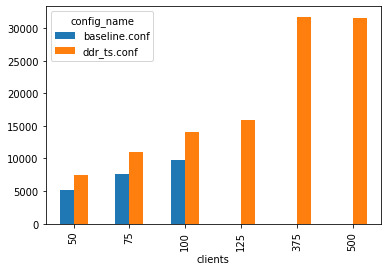

In [29]:
remove_constant_columns(throughput_df, ["config_name", "throughput"])
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = throughput_df.columns.drop([pivot_values, pivot_columns, "version"])
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values)
pivoted.sort_index().plot.bar()

## Throughput with varying clients

In [30]:
pivoted = throughput_df.pivot(index=["wl:mh"], columns=["config_name", "wl:mh_zipf"], values="throughput")
pivoted.plot(marker='.', ylabel='throughput (tps/s)', title='Throughput with varying clients')
plt.grid("on")

KeyError: 'wl:mh'

In [ ]:
pivoted = throughput_df.pivot(index=["wl:mh"], columns=["config_name", "clients"], values="throughput")
pivoted.plot(marker='.', ylabel='throughput (tps/s)', title='Throughput with varying clients')
plt.grid("on")

# Latency

In [21]:
# Extract all prefixes in the index
prefixes = index_sdf.select("prefix").where(col("clients") == 100).toPandas()["prefix"].to_list()

latency_sdfs = []
for p in prefixes:
    lat_sdf = latency(spark, p, where=(F.size("replicas") == 2))\
        .withColumn("prefix", lit(p))\
        .join(index_sdf.where(col("prefix") == p), on="prefix")
    latency_sdfs.append(lat_sdf)
#         .sample(False, 0.1)\

latency_sdf = latency_sdfs[0]
for l in latency_sdfs[1:]:
    latency_sdf = latency_sdf.union(l)

latency_df = latency_sdf\
    .withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))\
    .groupBy("coordinator_region", "config_name")\
    .agg(
        F.percentile_approx("latency", 0.2, 100000).alias("latency_20"),
        F.percentile_approx("latency", 0.5, 100000).alias("latency_50"),
        F.percentile_approx("latency", 0.90, 100000).alias("latency_90"),
        F.percentile_approx("latency", 0.99, 100000).alias("latency_99"),
    )\
    .toPandas()

latency_df

,coordinator_region,config_name,latency_20,latency_50,latency_90,latency_99
0,7,ddr_only.conf,120.972288,194.916864,269.532160,494.398976
1,0,ddr_ts.conf,90.549760,139.814144,199.219456,232.900864
2,1,ddr_only.conf,78.616832,153.139968,210.762496,227.211008
3,2,baseline.conf,94.747136,102.311168,245.931520,279.730944
4,6,ddr_only.conf,93.277952,104.660992,214.964224,230.060800
5,7,baseline.conf,215.710464,252.901376,284.503040,381.216000
6,2,ddr_only.conf,23.490048,85.367040,238.259200,268.567552
7,3,baseline.conf,100.223232,225.172736,257.487104,288.720896
8,4,ddr_ts.conf,48.513280,96.847104,223.595264,3032.966400
9,5,baseline.conf,176.987904,226.194176,261.902080,337.759488


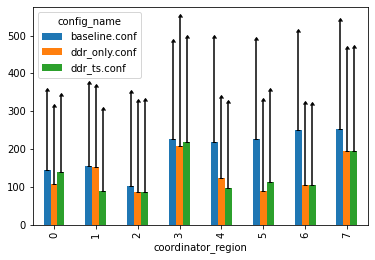

In [22]:
pivot_20 = latency_df.pivot(index="coordinator_region", columns="config_name", values="latency_20")
pivot_50 = latency_df.pivot(index="coordinator_region", columns="config_name", values="latency_50")
pivot_90 = latency_df.pivot(index="coordinator_region", columns="config_name", values="latency_90")
pivot_99 = latency_df.pivot(index="coordinator_region", columns="config_name", values="latency_99")

_, ax = plt.subplots(1, 1)
pivot_50.sort_index().plot.bar(ax=ax, yerr=pivot_90, error_kw={"capsize": 2, 'solid_capstyle': 'butt', 'lolims': True})
plt.yscale('linear')

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, latency_sdf.select("latency").where(col("wl:mh") == "25").where(col("clients") == "400").toPandas()["latency"], label="zipf_0_25", linewidth=0, marker='o')
# plot_cdf(ax, latency_sdf.select("latency").where(col("wl:mh") == "50").where(col("clients") == "400").toPandas()["latency"], label="zipf_0_50", linewidth=0, marker='o')
# plot_cdf(ax, latency_sdf.select("latency").where(col("wl:mh") == "75").where(col("clients") == "400").toPandas()["latency"], label="zipf_0_75", linewidth=0, marker='o')

plot_cdf(ax, latency_sdf.select("latency").where(col("wl:mh") == "25").where(col("clients") == "800").toPandas()["latency"], label="zipf_1_25", linewidth=0, marker='o')
# plot_cdf(ax, latency_sdf.select("latency").where(col("wl:mh") == "50").where(col("clients") == "800").toPandas()["latency"], label="zipf_1_50", linewidth=0, marker='o')
# plot_cdf(ax, latency_sdf.select("latency").where(col("wl:mh") == "75").where(col("clients") == "800").toPandas()["latency"], label="zipf_1_75", linewidth=0, marker='o')

plt.legend()

In [ ]:
# Extract all prefixes in the index
latency_pctl_df = index_sdf.select("prefix").toPandas().set_index("prefix")
# Compute the latency percentiles of each prefix
latency_pctl_df[["p50_latency", "p99_latency"]] =\
    latency_pctl_df.index.map(
        lambda p: latency(spark, p, [0.50, 0.99], F.size("replicas") > 1)
            .first()
            .percentiles
    )\
    .to_list()
# Associate metadata from the index to the latency percentiles
latency_pctl_df = latency_pctl_df.join(index_sdf.toPandas().set_index("prefix"), on="prefix").reset_index(drop=True)
# Cast columns to appropriate types 
latency_pctl_df = latency_pctl_df.convert_dtypes()

latency_pctl_df

In [ ]:
remove_constant_columns(latency_pctl_df, ["config_name"])

pivot_columns = "config_name"
pivot_index = latency_pctl_df.columns.drop([pivot_columns, "p50_latency", "p99_latency"])
pivoted_50 = latency_pctl_df[latency_pctl_df["wl:hot"] == "10000"].pivot(index=pivot_index, columns=pivot_columns, values="p50_latency")
pivoted_99 = latency_pctl_df[latency_pctl_df["wl:hot"] == "10000"].pivot(index=pivot_index, columns=pivot_columns, values="p99_latency")

_, ax = plt.subplots(1, 1)
pivoted_50.sort_index().plot.bar(ax=ax, yerr=pivoted_99, error_kw={"capsize": 2, 'solid_capstyle': 'butt', 'lolims': True})
plt.yscale('log')

In [ ]:
latency_hot_10000 = index_sdf.select("prefix", "config_name", "clients")\
    .where(col("wl:hot") == 10000)\
    .orderBy("clients")\
    .toPandas()

rows = 2
cols = 5
_, ax = plt.subplots(rows, cols, figsize=(15, 5))

clients_values = latency_hot_10000["clients"].unique()
for i, clients in enumerate(clients_values):
    filtered_clients = latency_hot_10000.loc[latency_hot_10000.clients == clients]

    filtered_baseline = filtered_clients.loc[filtered_clients.config_name == "baseline.conf"]
    print(filtered_baseline.prefix.iloc[0])
    baseline = latency(spark, filtered_baseline.prefix.iloc[0], where=F.size("replicas") == 1).cache()
    
    filtered_ddr_ts = filtered_clients.loc[filtered_clients.config_name == "ddr_ts.conf"]
    print(filtered_ddr_ts.prefix.iloc[0])
    ddr_ts = latency(spark, filtered_ddr_ts.prefix.iloc[0], where=F.size("replicas") == 1).cache()

    r, c = i // cols, i % cols
    plot_cdf(ax[r, c], baseline.toPandas()["latency"], label="baseline", linewidth=0, marker='o')
    plot_cdf(ax[r, c], ddr_ts.toPandas()["latency"], label="ddr", linewidth=0, marker='o')
    ax[r, c].set_title(f"clients = {clients}")
    ax[r, c].set_xlabel("latency (ms)")

plt.legend()
plt.tight_layout()

In [ ]:
latency_hot_10000 = index_sdf.select("prefix", "config_name", "clients")\
    .where(col("wl:hot") == 50)\
    .orderBy("clients")\
    .toPandas()

rows = 2
cols = 5
_, ax = plt.subplots(rows, cols, figsize=(15, 5))

clients_values = latency_hot_10000["clients"].unique()
for i, clients in enumerate(clients_values):
    filtered_clients = latency_hot_10000.loc[latency_hot_10000.clients == clients]

    filtered_baseline = filtered_clients.loc[filtered_clients.config_name == "baseline.conf"]
    print(filtered_baseline.prefix.iloc[0])
    baseline = latency(spark, filtered_baseline.prefix.iloc[0]).cache()
    
    filtered_ddr_ts = filtered_clients.loc[filtered_clients.config_name == "ddr_ts.conf"]
    print(filtered_ddr_ts.prefix.iloc[0])
    ddr_ts = latency(spark, filtered_ddr_ts.prefix.iloc[0]).cache()

    r, c = i // cols, i % cols
    plot_cdf(ax[r, c], baseline.toPandas()["latency"], label="baseline", linewidth=0, marker='o')
    plot_cdf(ax[r, c], ddr_ts.toPandas()["latency"], label="ddr", linewidth=0, marker='o')
    ax[r, c].set_title(f"clients = {clients}")
    ax[r, c].set_xlabel("latency (ms)")

plt.legend()
plt.tight_layout()

file:/home/ctring/data/slog/main/tpcc/baseline-clients50mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients50mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients62mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients62mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients75mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients75mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients87mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients87mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients100mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients100mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients112mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients112mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients125mh_zipf1
file:/home/ctring/data/slog/main/tpcc/ddr_ts-clients125mh_zipf1
file:/home/ctring/data/slog/main/tpcc/baseline-clients250mh_zipf1
file:/home/ctring/data/slog/main

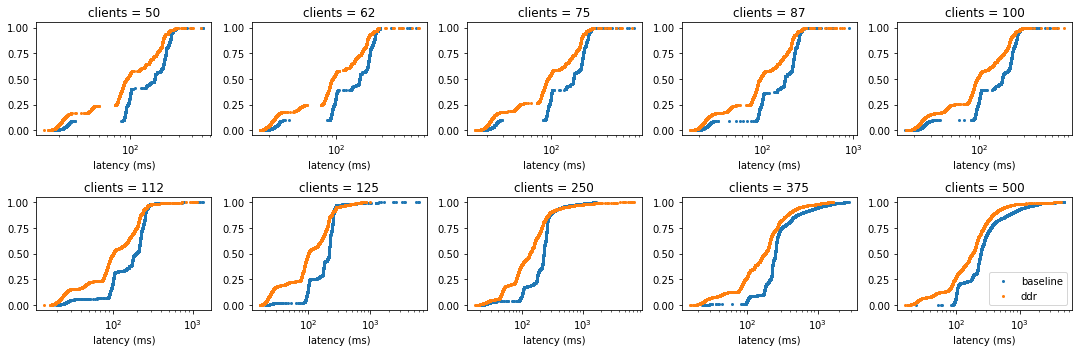

In [266]:
latency_tpcc = index_sdf.select("prefix", "config_name", "clients")\
    .where(col("wl:mh_zipf") == "1")\
    .orderBy("clients")\
    .toPandas()

rows = 2
cols = 5
_, ax = plt.subplots(rows, cols, figsize=(15, 5))

clients_values = latency_tpcc["clients"].unique()
for i, clients in enumerate(clients_values):
    filtered_clients = latency_tpcc.loc[latency_tpcc.clients == clients]

    filtered_baseline = filtered_clients.loc[filtered_clients.config_name == "baseline.conf"]
    print(filtered_baseline.prefix.iloc[0])
    baseline = latency(spark, filtered_baseline.prefix.iloc[0], where=F.size("replicas") == 2).cache()
    
    filtered_ddr_ts = filtered_clients.loc[filtered_clients.config_name == "ddr_ts.conf"]
    print(filtered_ddr_ts.prefix.iloc[0])
    ddr_ts = latency(spark, filtered_ddr_ts.prefix.iloc[0], where=F.size("replicas") == 2).cache()

    r, c = i // cols, i % cols
    plot_cdf(ax[r, c], baseline.toPandas()["latency"], label="baseline", linewidth=0, marker='o')
    plot_cdf(ax[r, c], ddr_ts.toPandas()["latency"], label="ddr", linewidth=0, marker='o')
    ax[r, c].set_title(f"clients = {clients}")
    ax[r, c].set_xlabel("latency (ms)")

plt.legend()
plt.tight_layout()

In [31]:
# Extract all prefixes in the index
prefixes = index_sdf.select("prefix").where(col("clients") == 100).toPandas()["prefix"].to_list()

latency_sdfs = []
for p in prefixes:
    lat_sdf = latency(spark, p, where=(F.size("replicas") == 2))\
        .withColumn("prefix", lit(p))\
        .join(index_sdf.where(col("prefix") == p), on="prefix")
    latency_sdfs.append(lat_sdf)
#         .sample(False, 0.1)\

latency_sdf = latency_sdfs[0]
for l in latency_sdfs[1:]:
    latency_sdf = latency_sdf.union(l)

latency_df = latency_sdf\
    .withColumn("coordinator_region", (col("coordinator") / 3).cast(T.IntegerType()))\
    .toPandas()

latency_df

,prefix,txn_id,coordinator,replicas,partitions,latency,version,config_name,duration,txns,...,wl:mh_homes,wl:mp,wl:hot_records,wl:mp_parts,wl:hot,wl:writes,wl:value_size,wl:nearest,wl:sp_partition,coordinator_region
0,file:///home/ctring/data/slog/main/ycsb/baseli...,1531504,4,"[1, 2]",[0],85.492736,1.0.879,baseline.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,1
1,file:///home/ctring/data/slog/main/ycsb/baseli...,1546704,4,"[1, 2]",[0],87.133952,1.0.879,baseline.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,1
2,file:///home/ctring/data/slog/main/ycsb/baseli...,1745304,4,"[1, 2]",[1],88.968960,1.0.879,baseline.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,1
3,file:///home/ctring/data/slog/main/ycsb/baseli...,1803905,5,"[1, 2]","[0, 1]",89.609472,1.0.879,baseline.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,1
4,file:///home/ctring/data/slog/main/ycsb/baseli...,1827703,3,"[1, 3]",[0],96.742912,1.0.879,baseline.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7705,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1757302,2,"[0, 3]",[2],92.552960,1.0.883,ddr_ts.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,0
7706,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1961602,2,"[0, 1]",[0],21.183232,1.0.883,ddr_ts.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,0
7707,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,2050802,2,"[0, 4]",[0],134.648320,1.0.883,ddr_ts.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,0
7708,file:///home/ctring/data/slog/main/ycsb/ddr_ts...,1849201,1,"[0, 1]","[0, 1]",21.157376,1.0.883,ddr_ts.conf,15,1000000,...,2,50,2,2,100000,10,100,1,-1,0


In [32]:
_, ax = plt.subplots(1, 1)
region = 
plot_cdf(ax, latency_df[(latency_df.coordinator_region == region) & (latency_df.config_name == "baseline.conf")]["latency"], label="baseline", linewidth=0, marker='o')
plot_cdf(ax, latency_df[(latency_df.coordinator_region == region) & (latency_df.config_name == "ddr_ts.conf")]["latency"], label="ddr_ts", linewidth=0, marker='o')
plt.legend()

SyntaxError: invalid syntax (<ipython-input-32-a354f938134e>, line 2)

In [307]:
for i in range(8):
    print(len(latency_df[(latency_df.coordinator_region == i) & (latency_df.config_name == "baseline.conf")]))
    print(len(latency_df[(latency_df.coordinator_region == i) & (latency_df.config_name == "ddr_ts.conf")]))
    print()

586
513

410
459

818
797

195
172

556
528

385
453

350
312

214
192

